In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.chunking import gpu_batch
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.proc import dai_yuan, linear
import holotomocupy.chunking as chunking
from holotomocupy.utils import *
import h5py
from holotomocupy.proc import remove_outliers



astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 2048  # object size in each dimension

npos = 16  # number of code positions
detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:1]-sx0
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size
# allow padding if there are shifts of the probe
pad = n//4
# sample size after demagnification
ne = n+2*pad

show = True

flg = f'1'
path = f'/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01/'

In [3]:
voxelsize,distances[0]

(1.0000052453125002e-08, 0.004200126721875001)

# Read data

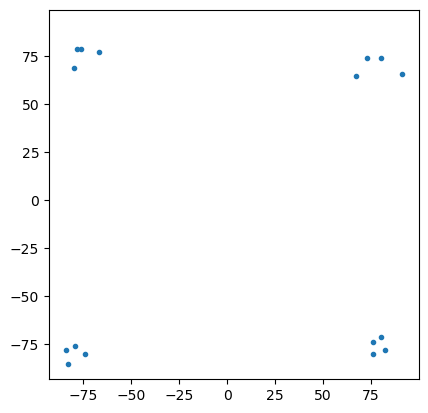

/tmp/ipykernel_699934/3230064443.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  rdata[:,k] = ST(rdata[:,k],shifts_code[:,k])


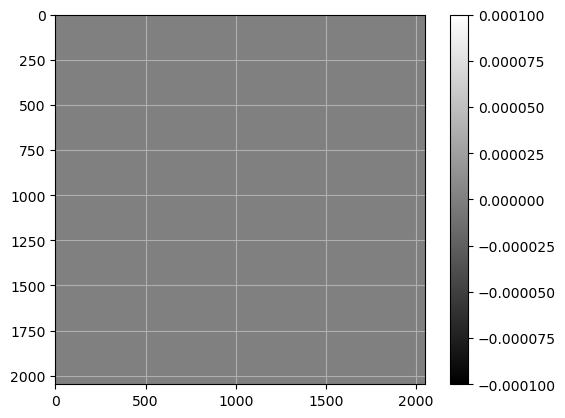

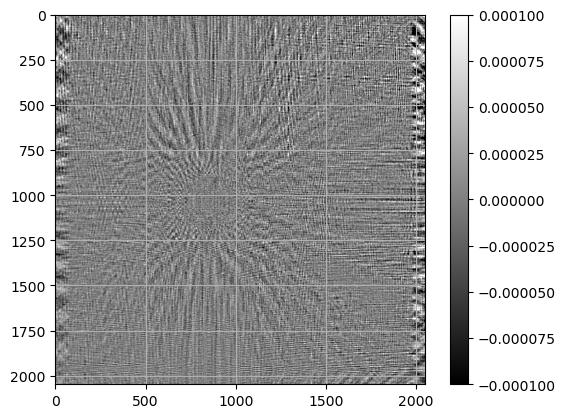

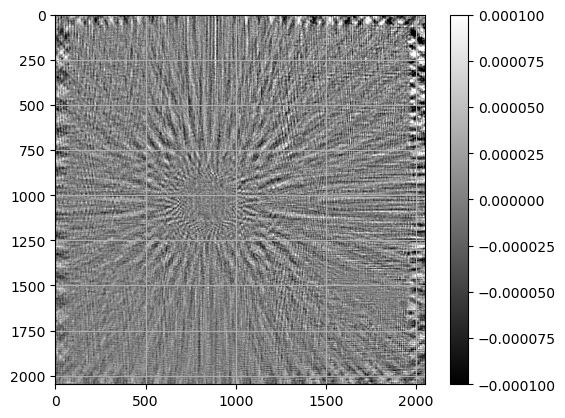

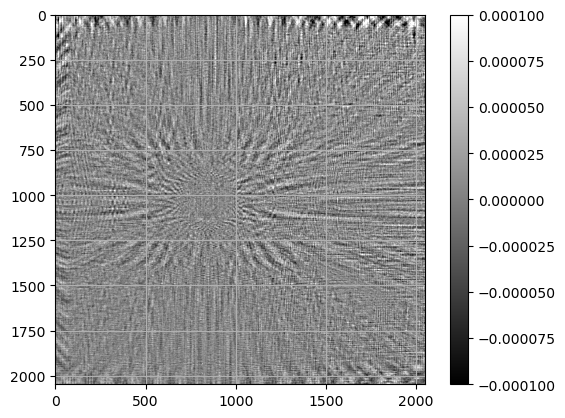

0


In [4]:
nref = 20
ndark = 20
data00 = np.zeros([1,npos,n,n],dtype='float32')
ref00 = np.zeros([nref,n,n],dtype='float32')
dark00 = np.zeros([ndark,n,n],dtype='float32')
with h5py.File(f'{path}SiemensLH_33keV_010nm_holoNfpScan_010000.h5','r') as fid:
    data00[:] = fid['/entry_0000/measurement/data'][:npos][np.newaxis]
with h5py.File(f'{path}/ref_0000.h5','r') as fid:
    ref00[:]=fid['/entry_0000/measurement/data'][:nref]
with h5py.File(f'{path}/dark_0000.h5','r') as fid:
    dark00[:]=fid['/entry_0000/measurement/data'][:ndark]
with h5py.File(f'{path}SiemensLH_33keV_010nm_holoNfpScan_010000.h5','r') as fid:
    spz = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spz']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize
    spy = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spy']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize

plt.plot(spy,spz,'.')
plt.axis('square')
plt.show()
shifts_code = np.zeros([1,npos,2],dtype='float32')
shifts_code[:,:,1] = spy
shifts_code[:,:,0] = -spz

for k in range(npos):
    radius = 7
    threshold = 20000
    data00[:,k] = remove_outliers(data00[:,k], radius, threshold)
ref00[:] = remove_outliers(ref00[:], radius, threshold)     


data00-=np.mean(dark00)
ref00-=np.mean(dark00)

data00[data00<=0] = 0
ref00[ref00<=0] = 0

data00/=np.mean(ref00)
ref00/=np.mean(ref00)

rdata = (data00-np.mean(dark00,axis=0))/(np.mean(ref00,axis=0)-np.mean(dark00,axis=0))

for k in range(npos):
    rdata[:,k] = ST(rdata[:,k],shifts_code[:,k])

for k in range(0,npos,4):
    plt.imshow(rdata[0,k]-rdata[0,0],cmap='gray',vmin=-1e-4,vmax=1e-4)
    plt.grid('on')
    plt.colorbar()
    plt.show()

print(np.sum(np.isnan(data00)))


# Construct operators


In [5]:
def _fwd_holo(psi, shifts_code, prb):
    prb = cp.array(prb)
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])

        # shift and crop the code 
        psir = S(psir, shifts_code[:, i])
        nee = psir.shape[1]        
        psir = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]

        # multiply by the probe
        psir *= prbr
        
        # propagate to the detector
        psir = G(psir, wavelength, voxelsize, distances[i])
        
        # unpad
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code,  prb)

def _adj_holo(data, shifts_code, prb):
    prb = cp.array(prb)
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        prbr = cp.tile(prb,[data.shape[0],1,1])        
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))

        psir = GT(psir, wavelength, voxelsize, distances[j])        
        psir *= cp.conj(prbr)
        psir = cp.pad(psir,((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shifts_code[:,j])
        # psi+=psir
    return psi

@gpu_batch
def _adj_holo_prb(data, shifts_code, psi):
    psi = cp.array(psi)
    shifts_code = cp.array(shifts_code)       
    prb = cp.zeros([data.shape[0], n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        prbr = np.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))        
        psir = psi.copy()

        prbr = GT(prbr, wavelength, voxelsize, distances[j])
        psir = S(psir, shifts_code[:, j])
        psir = psir[:, ne//2-n//2-pad:ne//2+n//2+pad, ne//2-n//2-pad:ne//2+n//2+pad]
        prbr *= cp.conj(psir)

        prb += prbr
    return prb

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code, prb)
def adj_holo(data, prb):
    return _adj_holo(data, shifts_code, prb)
def adj_holo_prb(data, psi):
    return np.sum(_adj_holo_prb(data, shifts_code, psi), axis=0)[np.newaxis]

# adjoint tests
data = cp.array(data00)
arr1 = cp.pad(data[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts_code = cp.array(shifts_code)
arr2 = fwd_holo(arr1, prb1)
arr3 = adj_holo(arr2, prb1)
arr4 = adj_holo_prb(arr2, arr1)

print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(prb1*cp.conj(arr4))}==\n{cp.sum(arr2*cp.conj(arr2))}')

(83332184+98.8125j)==
(83336640+0.00010235102672595531j)
(83336640-0.8359375j)==
(83336640+0.00010235102672595531j)


### Divide by reference image for 1step Paganin reconsturction

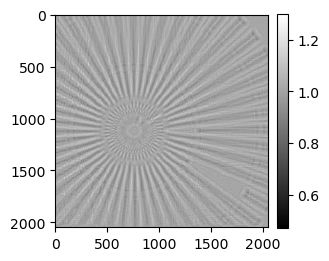

In [6]:
ref0 = cp.array(cp.mean(ref00,axis=0))[np.newaxis,np.newaxis]
data00 = cp.array(data00)
rdata = data00/ref0
mshow((rdata)[0,0],show,vmax=1.3)

/tmp/ipykernel_699934/3384234118.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganin[:,j] = ST(r,shifts_code[:,j])
/tmp/ipykernel_699934/3384234118.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganinr[:,j] = ST(rr,shifts_code[:,j])


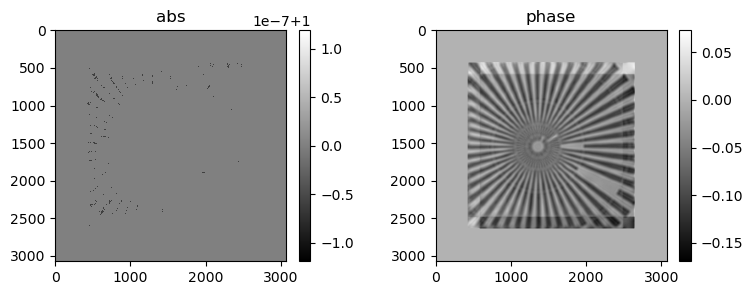

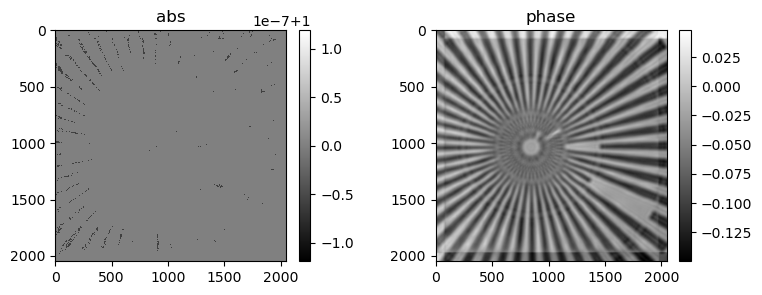

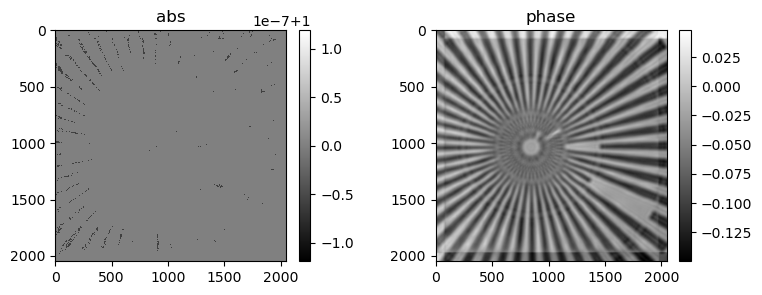

In [7]:
recMultiPaganin = cp.zeros([1,npos,ne,ne],dtype='float32')
recMultiPaganinr = cp.zeros([1,npos,ne,ne],dtype='float32')# to compensate for overlap
for j in range(0,npos):
    r = cp.array(multiPaganin(rdata[:,j:j+1],
                         distances[j:j+1], wavelength, voxelsize,  24.05, 9e-3))    
    rr = r*0+1 # to compensate for overlap
    r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    recMultiPaganin[:,j] = ST(r,shifts_code[:,j])
    recMultiPaganinr[:,j] = ST(rr,shifts_code[:,j])
    
recMultiPaganin = cp.sum(recMultiPaganin,axis=1)
recMultiPaganinr = cp.sum(recMultiPaganinr,axis=1)

# avoid division by 0
recMultiPaganinr[np.abs(recMultiPaganinr)<1e-4] = 1

# compensate for overlap
recMultiPaganin /= recMultiPaganinr
recMultiPaganin = cp.exp(1j*recMultiPaganin)

mshow_polar(recMultiPaganin[0],show)
mshow_polar(recMultiPaganin[0,pad:-pad,pad:-pad],show)
mshow_polar(recMultiPaganin[0,512:-512,512:-512],show)


In [8]:
@gpu_batch
def _fwd_holo0(prb):
    data = cp.zeros([1, npos, n, n], dtype='complex64')
    for j in range(npos):
        # ill shift for each acquisition
        prbr = S(prb)
        # propagate illumination
        data[:, j] = G(prbr, wavelength, voxelsize, distances[0])[:, pad:n+pad, pad:n+pad]
    return data
def fwd_holo0(prb):
    return _fwd_holo0(prb)

@gpu_batch
def _adj_holo0(data):
    prb = cp.zeros([1, n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        # ill shift for each acquisition
        prbr = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        # propagate illumination
        prbr = GT(prbr, wavelength, voxelsize, distances[0])
        # ill shift for each acquisition
        prb += prbr
    return prb
def adj_holo0(data):
    return _adj_holo0(data)

# adjoint test
data = cp.array(data00[0, :])
ref = cp.array(ref0)
prb1 = cp.array(ref[0, :1]+1j*ref[0, :1]).astype('complex64')
prb1 = cp.pad(prb1, ((0, 0), (pad, pad), (pad, pad)))
arr2 = fwd_holo0(prb1)
arr3 = adj_holo0(arr2)

print(f'{np.sum(prb1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

(161127104+0.232421875j)==
(161127088+0.0013335652183741331j)


# Estimation with the reference data

0) gammaprbh=0.03124983049929142, err=9.11686e+05


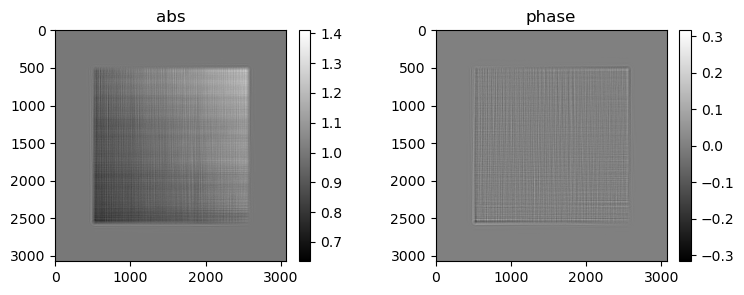

1) gammaprbh=570.7423095703125, err=9.10953e+05
2) gammaprbh=0.031249836087226868, err=2.27927e+05
3) gammaprbh=0.03125007450580597, err=2.27741e+05
4) gammaprbh=0.03124983422458172, err=5.69826e+04
5) gammaprbh=0.03124738484621048, err=5.69359e+04
6) gammaprbh=0.031249836087226868, err=1.42458e+04
7) gammaprbh=0.031250160187482834, err=1.42342e+04


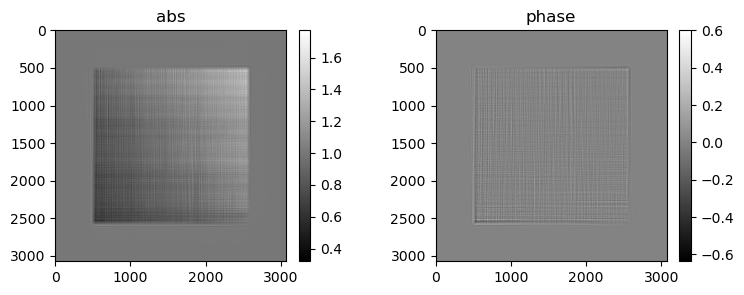

8) gammaprbh=0.03124983236193657, err=3.56150e+03
9) gammaprbh=0.03125125914812088, err=3.55857e+03
10) gammaprbh=0.03124983422458172, err=8.90387e+02
11) gammaprbh=0.03125074505805969, err=8.89659e+02
12) gammaprbh=0.03124983422458172, err=2.22598e+02
13) gammaprbh=0.031248239800333977, err=2.22414e+02
14) gammaprbh=0.03124983422458172, err=5.56509e+01


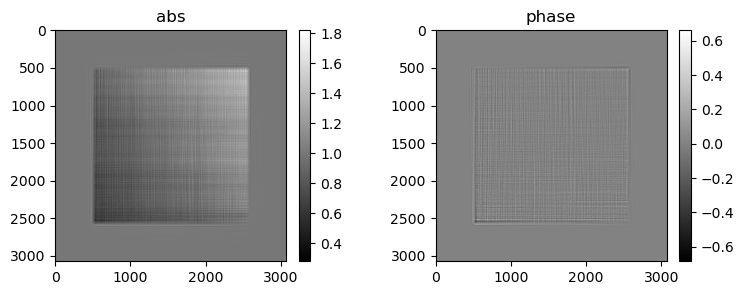

15) gammaprbh=0.031249908730387688, err=5.56074e+01
16) gammaprbh=0.03124983236193657, err=1.39125e+01
17) gammaprbh=0.031251102685928345, err=1.39013e+01
18) gammaprbh=0.03124983422458172, err=3.47799e+00
19) gammaprbh=0.031247153878211975, err=3.47485e+00
20) gammaprbh=0.03124983236193657, err=8.69503e-01
21) gammaprbh=0.031244395300745964, err=8.69001e-01


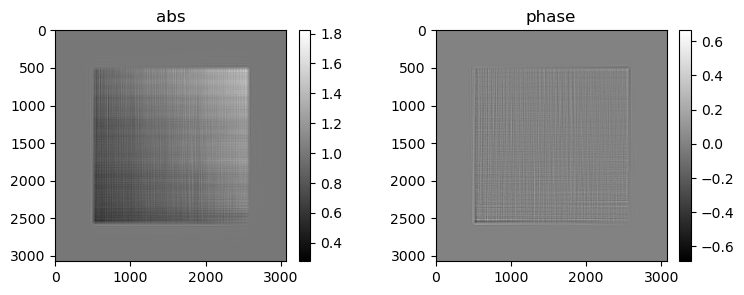

22) gammaprbh=0.031249837949872017, err=2.17281e-01
23) gammaprbh=0.03124765120446682, err=2.17236e-01
24) gammaprbh=0.03124983236193657, err=5.43289e-02
25) gammaprbh=0.031248828396201134, err=5.42724e-02
26) gammaprbh=0.03124983422458172, err=1.35849e-02
27) gammaprbh=0.03125091642141342, err=1.35792e-02
28) gammaprbh=0.031249845400452614, err=3.39915e-03


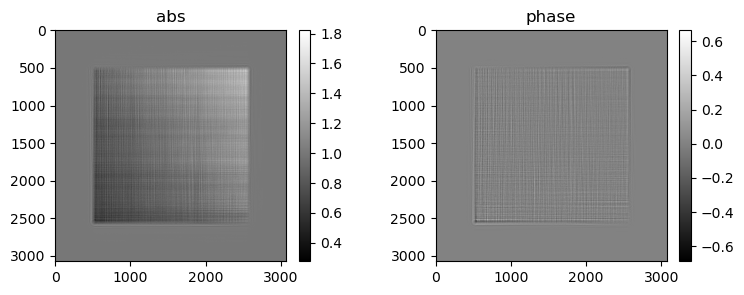

29) gammaprbh=0.031249025836586952, err=3.39686e-03
30) gammaprbh=0.031249841675162315, err=8.49682e-04
31) gammaprbh=0.03125007823109627, err=8.49426e-04


In [9]:
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while (minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if (gamma <= 1e-12):  # direction not found
        # print('no direction')
        gamma = 0
    return gamma
def hessianprb2(Lpsi,Lksi,Leta,ref):
    v1 = cp.abs(Lpsi)-ref
    v2 = cp.real(cp.conj(Lksi)*Leta)/cp.abs(Lpsi)            
    v3 = cp.real(cp.conj(Lpsi)*Lksi) * cp.real(cp.conj(Lpsi)*Leta) / cp.abs(Lpsi)**3    
    v4 = cp.real(cp.conj(Lpsi)*Lksi)/cp.abs(Lpsi)
    v5 = cp.real(cp.conj(Lpsi)*Leta)/cp.abs(Lpsi)
    return 2*(cp.sum(v1 * cp.conj(v2-v3)) + cp.sum(v4*cp.conj(v5)))

def cg_holo(ref, init_prb,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fprb):
        f = np.linalg.norm(np.abs(fprb)-ref)**2
        return f

   
    ref = np.sqrt(ref)
    prb = init_prb.copy()

    for i in range(pars['niter']):
        fprb0 = fwd_holo0(prb)
        gradprb = adj_holo0(fprb0-ref*np.exp(1j*np.angle(fprb0)))

        fgradprb = fwd_holo0(gradprb)

        if i == 0:
            etaprb = -gradprb            
            fetaprb = -fgradprb
        else:
            fetaprb = fwd_holo0(etaprb)
            beta = hessianprb2(fprb0,fgradprb,fetaprb,ref)/hessianprb2(fprb0,fetaprb,fetaprb,ref)            
            etaprb = -gradprb + beta*etaprb
            fetaprb = -fgradprb+beta*fetaprb
        gammaprbh = float(-cp.sum(cp.real(gradprb*cp.conj(etaprb)))/hessianprb2(fprb0,fetaprb,fetaprb,ref))
        prb += gammaprbh*etaprb
        

        if i % pars['err_step'] == 0:
            fprb0 = fwd_holo0(prb)
            err = minf(fprb0)
            print(f'{i}) {gammaprbh=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow_polar(prb[0],show)

    return prb

rec_prb0 = cp.ones([1, n+2*pad, n+2*pad], dtype='complex64')
ref = cp.array(ref0)
pars = {'niter': 32, 'err_step': 1, 'vis_step': 7, 'gammaprb': 0.5}
rec_prb0 = cg_holo(ref, rec_prb0, pars)

#### Reconstruction with the CG (Carlsson) with Hessians

0) gammah=0.030873989686369896, gammaprbh=0.031304869800806046, err=1.37770e+04


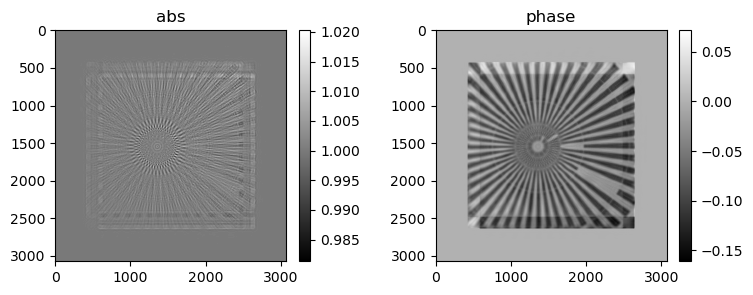

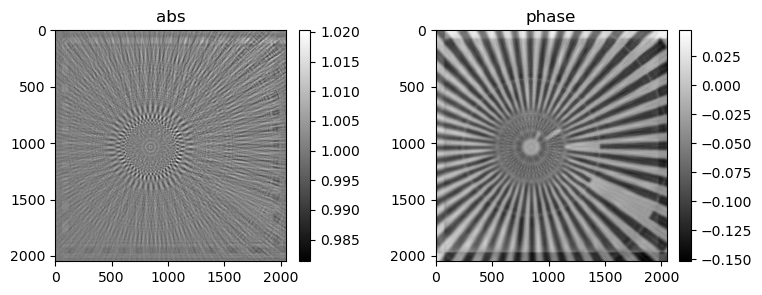

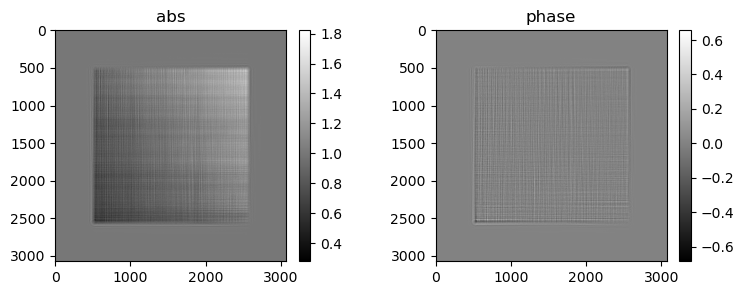

1) gammah=0.05364326760172844, gammaprbh=0.03485945612192154, err=1.33018e+04
2) gammah=0.03194475546479225, gammaprbh=0.03152495250105858, err=1.14916e+04
3) gammah=0.05606111139059067, gammaprbh=0.04222909361124039, err=1.12986e+04
4) gammah=0.03422221168875694, gammaprbh=0.032179683446884155, err=1.08226e+04
5) gammah=0.07009943574666977, gammaprbh=0.051368437707424164, err=1.07326e+04
6) gammah=0.03988635912537575, gammaprbh=0.033709701150655746, err=1.05693e+04
7) gammah=0.11619985848665237, gammaprbh=0.05227956920862198, err=1.05104e+04
8) gammah=0.055903203785419464, gammaprbh=0.0358436219394207, err=1.04233e+04
9) gammah=0.33884692192077637, gammaprbh=0.04242319241166115, err=1.03358e+04
10) gammah=0.08682131767272949, gammaprbh=0.03603939712047577, err=1.02290e+04
11) gammah=0.38888484239578247, gammaprbh=0.03909468278288841, err=1.00785e+04
12) gammah=0.09501391649246216, gammaprbh=0.042710788547992706, err=9.95777e+03
13) gammah=0.12080663442611694, gammaprbh=0.0411039181053

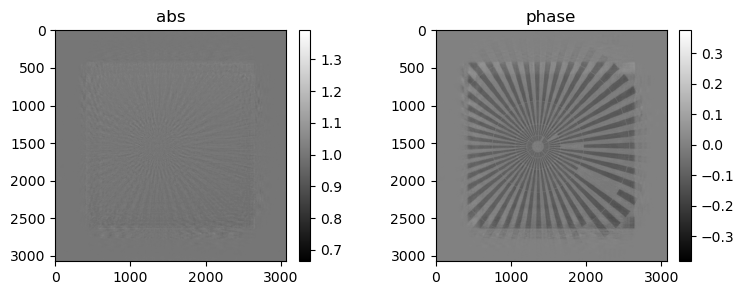

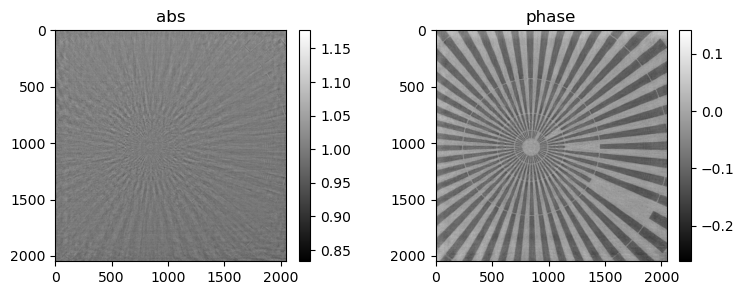

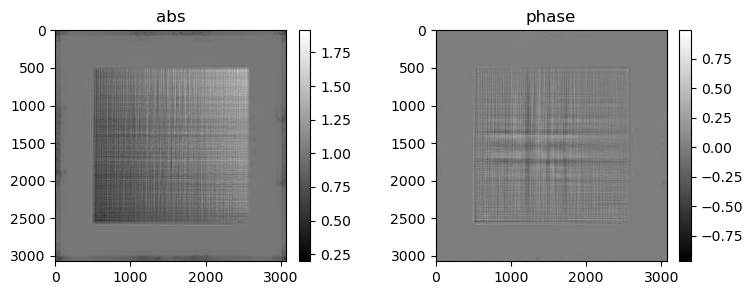

129) gammah=0.023095104843378067, gammaprbh=0.8309307098388672, err=6.48684e+03
130) gammah=0.044067710638046265, gammaprbh=0.10232651978731155, err=6.47366e+03
131) gammah=0.04913180321455002, gammaprbh=0.04603089764714241, err=6.47042e+03
132) gammah=0.028564514592289925, gammaprbh=0.09540034830570221, err=6.47011e+03
133) gammah=0.001325529534369707, gammaprbh=0.0958385318517685, err=6.46899e+03
134) gammah=0.017564745619893074, gammaprbh=1.935261607170105, err=6.46317e+03
135) gammah=0.1256808042526245, gammaprbh=0.06626716256141663, err=6.45117e+03
136) gammah=0.07729284465312958, gammaprbh=0.028775187209248543, err=6.44671e+03
137) gammah=0.03868778422474861, gammaprbh=0.30124086141586304, err=6.44087e+03
138) gammah=0.035842910408973694, gammaprbh=0.05918218195438385, err=6.43476e+03
139) gammah=0.038672588765621185, gammaprbh=0.01174338348209858, err=6.43461e+03
140) gammah=0.00010245703742839396, gammaprbh=0.1313939392566681, err=6.43248e+03
141) gammah=0.03970995172858238, ga

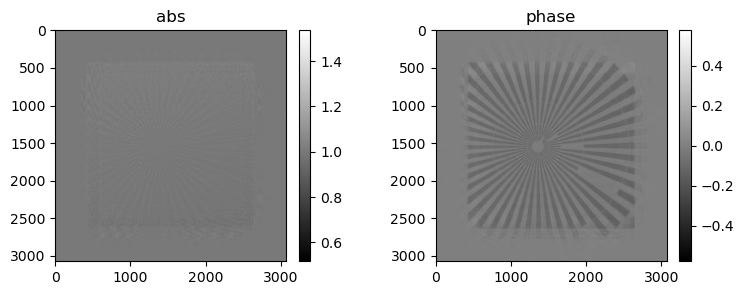

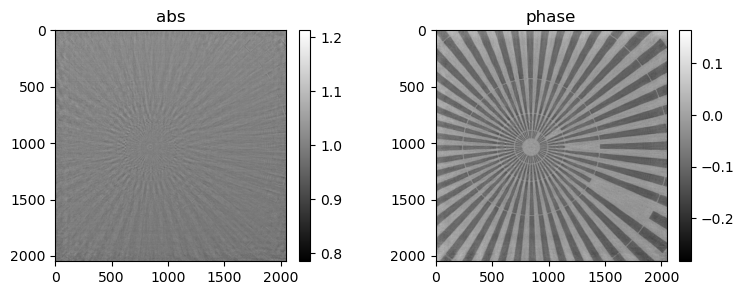

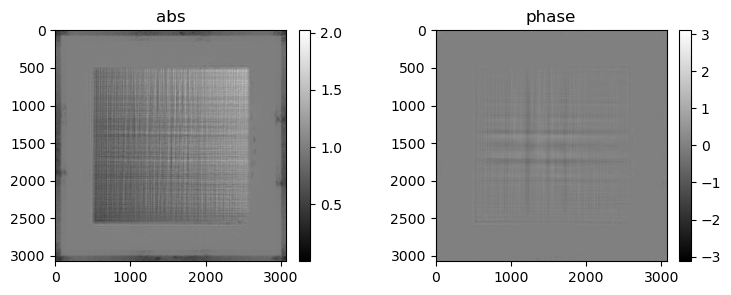

257) gammah=0.16042429208755493, gammaprbh=0.0948081985116005, err=5.63949e+03
258) gammah=0.09160012006759644, gammaprbh=0.12127794325351715, err=5.63827e+03
259) gammah=0.025252418592572212, gammaprbh=1.2776576280593872, err=5.63646e+03
260) gammah=0.1388229876756668, gammaprbh=0.06355343014001846, err=5.62765e+03
261) gammah=0.07684411853551865, gammaprbh=0.030598804354667664, err=5.62105e+03
262) gammah=0.08880163729190826, gammaprbh=0.10582134872674942, err=5.61954e+03
263) gammah=0.04917997121810913, gammaprbh=0.03722059726715088, err=5.61693e+03
264) gammah=0.012509840540587902, gammaprbh=0.11596217006444931, err=5.61664e+03
265) gammah=0.0005571950459852815, gammaprbh=0.053358253091573715, err=5.61566e+03
266) gammah=0.012733133509755135, gammaprbh=0.3610480725765228, err=5.61398e+03
267) gammah=0.041465874761343, gammaprbh=0.4095734655857086, err=5.60484e+03
268) gammah=0.047069866210222244, gammaprbh=0.23110923171043396, err=5.59241e+03
269) gammah=0.10061481595039368, gammap

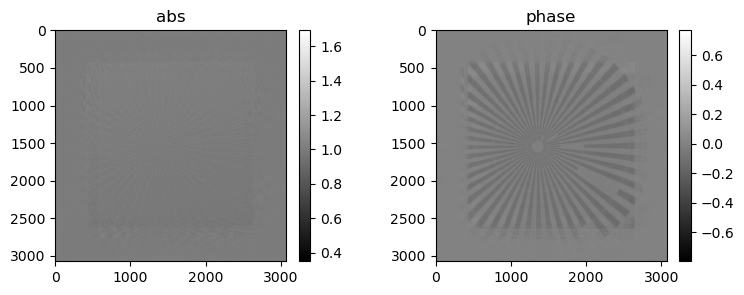

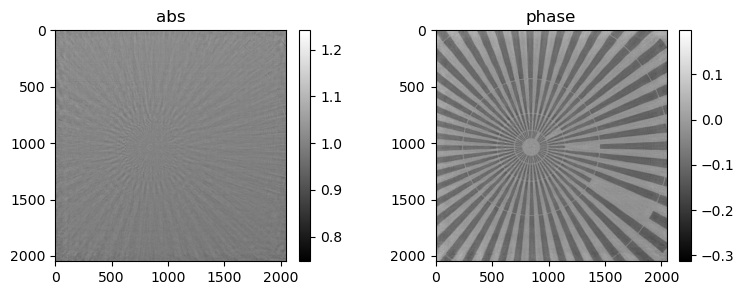

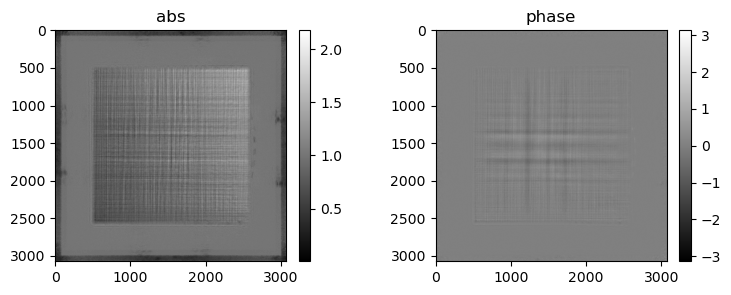

385) gammah=0.06708962470293045, gammaprbh=0.16082105040550232, err=4.93380e+03
386) gammah=0.07218476384878159, gammaprbh=0.12190960347652435, err=4.93116e+03
387) gammah=0.055060748010873795, gammaprbh=0.1656416654586792, err=4.92860e+03
388) gammah=0.05598162114620209, gammaprbh=0.12510588765144348, err=4.92633e+03
389) gammah=0.05203188955783844, gammaprbh=0.21765413880348206, err=4.92336e+03
390) gammah=0.05297550559043884, gammaprbh=0.35490357875823975, err=4.91558e+03
391) gammah=0.06005546450614929, gammaprbh=0.1877494901418686, err=4.90582e+03
392) gammah=0.059951283037662506, gammaprbh=0.12556390464305878, err=4.89951e+03
393) gammah=0.08969167619943619, gammaprbh=0.0394095815718174, err=4.89835e+03
394) gammah=0.0895894467830658, gammaprbh=0.09326811134815216, err=4.89770e+03
395) gammah=0.06424880772829056, gammaprbh=0.12171968817710876, err=4.89667e+03
396) gammah=0.0661783516407013, gammaprbh=0.15558946132659912, err=4.89577e+03
397) gammah=0.05575045198202133, gammaprbh=

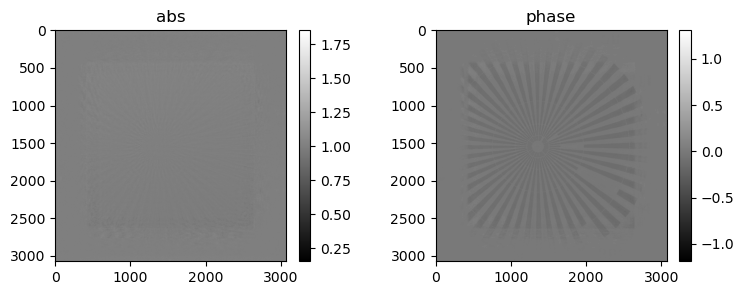

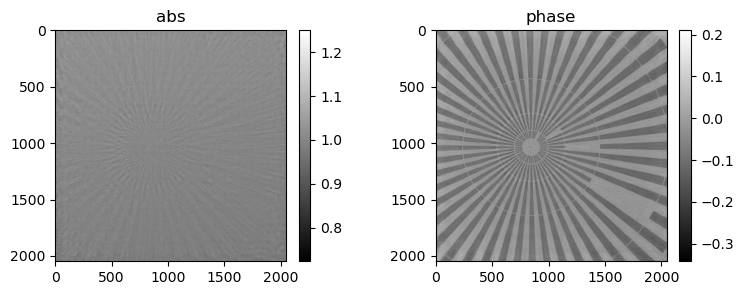

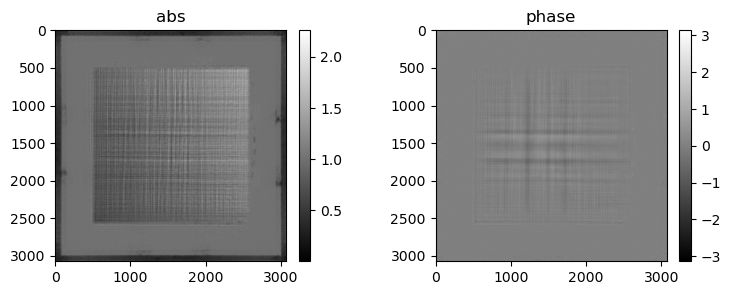

513) gammah=0.05997218191623688, gammaprbh=0.1254240870475769, err=4.36966e+03
514) gammah=0.10313902050256729, gammaprbh=0.11808717250823975, err=4.36842e+03
515) gammah=0.09290442615747452, gammaprbh=0.13411934673786163, err=4.36714e+03
516) gammah=0.08829251676797867, gammaprbh=0.11236251890659332, err=4.36617e+03
517) gammah=0.06873443722724915, gammaprbh=0.1917584389448166, err=4.36486e+03
518) gammah=0.04984857514500618, gammaprbh=0.30780357122421265, err=4.36160e+03
519) gammah=0.0612017959356308, gammaprbh=0.16618908941745758, err=4.35769e+03
520) gammah=0.08198920637369156, gammaprbh=0.09161729365587234, err=4.35623e+03
521) gammah=0.08729790896177292, gammaprbh=0.05370699241757393, err=4.35589e+03
522) gammah=0.08911995589733124, gammaprbh=0.07676376402378082, err=4.35540e+03
523) gammah=0.06354358047246933, gammaprbh=0.2437736988067627, err=4.35430e+03
524) gammah=0.06361202895641327, gammaprbh=0.30626818537712097, err=4.35119e+03
525) gammah=0.044100772589445114, gammaprbh=

KeyboardInterrupt: 

In [10]:
import time
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while (minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-5):
        gamma *= 0.5
    if (gamma <= 1e-5):  # direction not found
        gamma = 0
    return gamma

def hessian2(Lpsi,Lksi,Leta,data):
    v1 = cp.abs(Lpsi)-data
    v2 = cp.real(cp.conj(Lksi)*Leta)/cp.abs(Lpsi)            
    v3 = cp.real(cp.conj(Lpsi)*Lksi) * cp.real(cp.conj(Lpsi)*Leta) / cp.abs(Lpsi)**3    
    v4 = cp.real(cp.conj(Lpsi)*Lksi)/cp.abs(Lpsi)
    v5 = cp.real(cp.conj(Lpsi)*Leta)/cp.abs(Lpsi)
    return 2*(cp.sum(v1 * cp.conj(v2-v3)) + cp.sum(v4*cp.conj(v5)))

    
def hessianprb2(Lpsi,Lksi,Leta,data):
    v1 = cp.abs(Lpsi)-data
    v2 = cp.real(cp.conj(Lksi)*Leta)/cp.abs(Lpsi)            
    v3 = cp.real(cp.conj(Lpsi)*Lksi) * cp.real(cp.conj(Lpsi)*Leta) / cp.abs(Lpsi)**3    
    v4 = cp.real(cp.conj(Lpsi)*Lksi)/cp.abs(Lpsi)
    v5 = cp.real(cp.conj(Lpsi)*Leta)/cp.abs(Lpsi)
    return 2*(cp.sum(v1 * cp.conj(v2-v3)) + cp.sum(v4*cp.conj(v5)))

# def hessianprb02(Lpsi,Lksi,Leta,ref):
#     v1 = cp.abs(Lpsi)-ref
#     v2 = cp.real(cp.conj(Lksi)*Leta)/cp.abs(Lpsi)            
#     v3 = cp.real(cp.conj(Lpsi)*Lksi) * cp.real(cp.conj(Lpsi)*Leta) / cp.abs(Lpsi)**3    
#     v4 = cp.real(cp.conj(Lpsi)*Lksi)/cp.abs(Lpsi)
#     v5 = cp.real(cp.conj(Lpsi)*Leta)/cp.abs(Lpsi)
#     return 2*(cp.sum(v1 * cp.conj(v2-v3)) + cp.sum(v4*cp.conj(v5)))


def cg_holo(data,ref, init_psi,init_prb,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fpsi):
        f = np.linalg.norm(np.abs(fpsi)-data)**2
        return f

    data = np.sqrt(data)
    ref = np.sqrt(ref)
    psi = init_psi.copy()
    prb = init_prb.copy()

    conv = np.zeros(pars['niter'])
    gammah=0
    gammaprbh=0

    fpsi = fwd_holo(psi,prb)
        
    for i in range(pars['niter']):
        
        grad = adj_holo(fpsi-data*np.exp(1j*np.angle(fpsi)),prb)        
        fgrad = fwd_holo(grad,prb)
        
        if i == 0:
            eta = -grad            
            feta = -fgrad
        else:            
            feta = feta+gammaprbh*fetaprb
            # feta = fwd_holo(eta,prb)                                    
            # print('!!!',cp.linalg.norm(feta0-feta)/cp.linalg.norm(feta))
            beta = hessian2(fpsi,fgrad,feta,data)/hessian2(fpsi,feta,feta,data) 
            eta = -grad + beta*eta
            feta = -fgrad + beta*feta  
        
        gammah = float(-cp.sum(cp.real(grad*cp.conj(eta)))/hessian2(fpsi,feta,feta,data))
        gammah = line_search(minf, gammah, fpsi, feta)        
        if gammah==0:
            eta = -grad
            gammah = float(-cp.sum(cp.real(grad*cp.conj(eta)))/hessian2(fpsi,feta,feta,data))
            gammah = line_search(minf, gammah, fpsi, feta)        
        psi += gammah*eta
        fpsi += gammah*feta
        
        if pars['update_probe']:
            
            gradprb = adj_holo_prb(fpsi-data*np.exp(1j*np.angle(fpsi)),psi)
            fgradprb = fwd_holo(psi,gradprb)

            if i == 0:
                etaprb = -gradprb            
                fetaprb = -fgradprb
            else:
                fetaprb = fetaprb+gammah*feta
                # fetaprb = fwd_holo(psi,etaprb)
                # print('!!!',cp.linalg.norm(fetaprb-fetaprb0)/cp.linalg.norm(fetaprb))
                
                beta = hessianprb2(fpsi,fgradprb,fetaprb,data)/hessianprb2(fpsi,fetaprb,fetaprb,data) 
                etaprb = -gradprb + beta*etaprb
                fetaprb = -fgradprb+beta*fetaprb

            gammaprbh = float(-cp.sum(cp.real(gradprb*cp.conj(etaprb)))/hessianprb2(fpsi,fetaprb,fetaprb,data))            
            gammaprbh = line_search(minf, gammaprbh, fpsi, fetaprb)
            if gammaprbh==0:
                etaprb = -gradprb
                gammaprbh = float(-cp.sum(cp.real(gradprb*cp.conj(etaprb)))/hessianprb2(fpsi,fetaprb,fetaprb,data))            
                gammaprbh = line_search(minf, gammaprbh, fpsi, fetaprb)
            prb += gammaprbh*etaprb
            fpsi += gammaprbh*fetaprb       

        if i % pars['err_step'] == 0:
            err = minf(fpsi)
            conv[i] = err
            print(f'{i}) {gammah=}, {gammaprbh=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow_polar(psi[0],show)
            mshow_polar(psi[0,pad:-pad,pad:-pad],show)
            mshow_polar(prb[0],show)

    return psi,conv

# fully on gpu
rec_psi = recMultiPaganin.copy()
data = cp.array(data00.copy())
ref = cp.array(ref0.copy())

rec_prb = cp.array(rec_prb0.copy())#cp.abs(rec_prb0).astype('complex64')#*cp.exp().copy()
pars = {'niter': 5000, 'err_step': 1, 'vis_step': 128, 'update_probe':True}
rec_psi,conv = cg_holo(data,ref,rec_psi,rec_prb, pars)

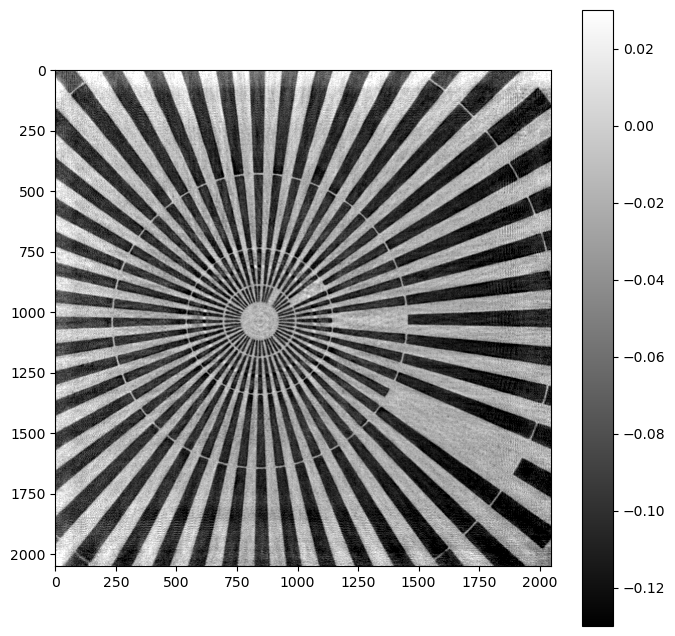

In [ ]:
crop = 256
plt.figure(figsize=(8,8))
plt.imshow(cp.angle(rec_psi[0,crop:-crop,crop:-crop]).get(),vmax=0.03,vmin=-0.13,cmap='gray')
plt.colorbar()